# Bus Parameter Validation

In this notebook we validate the electric bus parameters we'll input to FASTSim. This must be done before we can trust our FASTSim CDMX bus route simulation outputs.

We don't have a lot of great options to validate our simulation output against experimental results, so we'll compare our simulation results to the simulation results from the 2021 LOGIOS study of electrifying bus routes in Mexicali.

In [1]:
import os
import time
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from pathlib import Path

In [2]:
from fastsim import simdrive, vehicle, cycle

## The LOGIOS drive cycle

Route AB03, recorded on 5/20/21.

In [3]:
# Driving Cycle Data
INPUT_PATH = '../Data/LOGIOS Data/'

# Mexicali Shapefiles. Source: https://www.mexicali.gob.mx/sitioimip/geovisor/layers/geonode:distrito_pducp25/metadata_detail
SHAPEFILE_PATH = '../Data/LOGIOS Data/Mexicali Shapefiles/distrito_pducp25.shp'

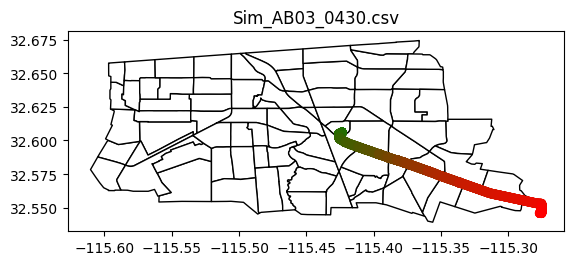

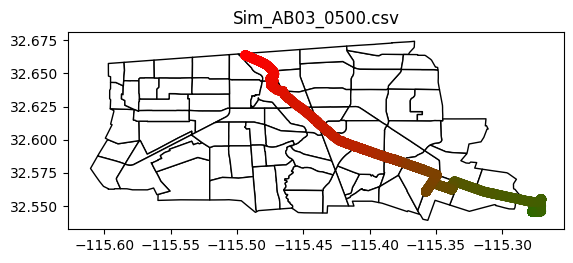

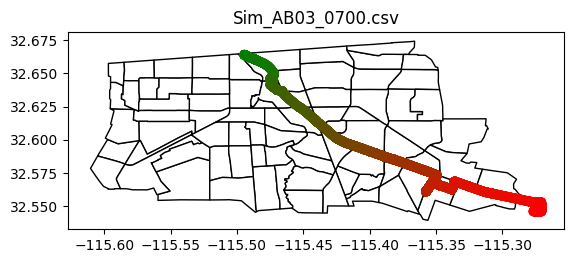

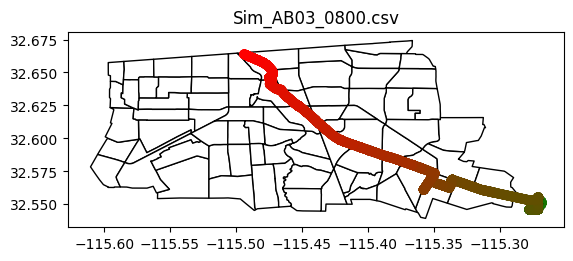

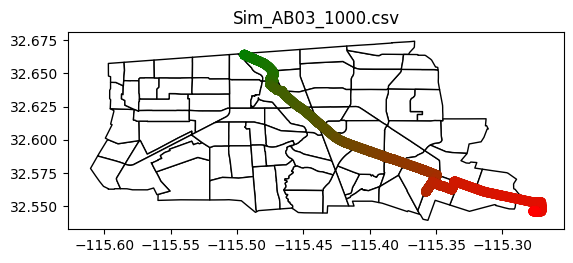

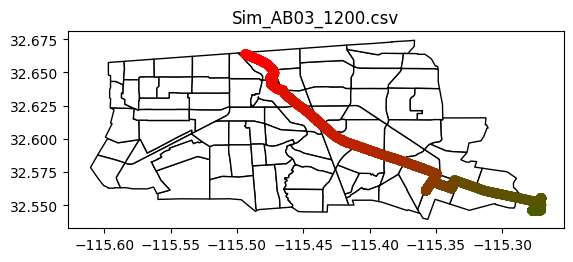

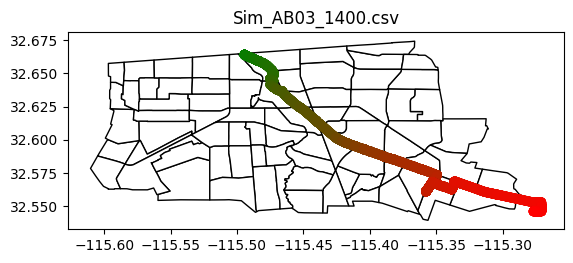

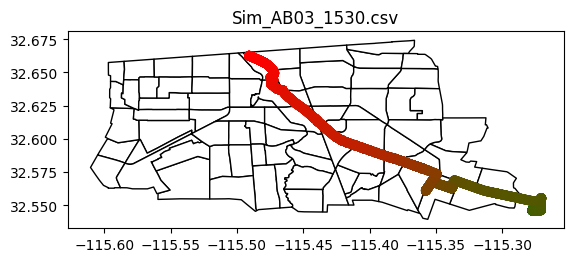

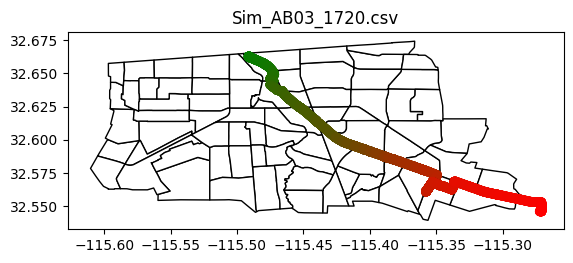

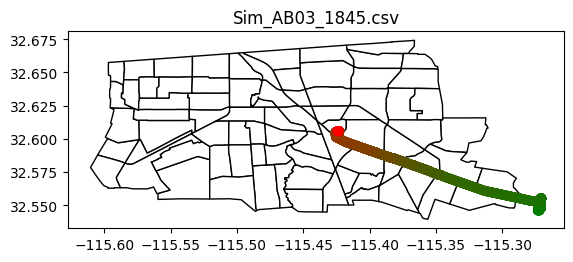

In [4]:
# Load LOGIOS drive cycles
drive_cycles_path = Path(INPUT_PATH) / '0520'
sorted_dc_files = sorted(drive_cycles_path.iterdir(), key=lambda f: str(f))

# Load Mexicali map shapefile
shapefile_path = Path(SHAPEFILE_PATH)
mexicali_map = gpd.read_file(shapefile_path) # At this point GeoDataFrame's CRS is epsg:32611\
mexicali_4326 = mexicali_map.to_crs("EPSG:4326") # Change CRS

# Color the bus route's directionality: Green at start, red at end.
cm = colors.LinearSegmentedColormap.from_list('namewhy', colors=['green', 'red'], N=10000)

# Visualize the route data in each CSV file
for file in sorted_dc_files:
    ax = mexicali_4326.plot(color='white', edgecolor='black')

    df = pd.read_csv(file)
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude)) # TODO Try specifying the CRS - see blog post
    gdf.plot(ax=ax, cmap=cm)

    plt.title(f'{file.name}')
    plt.show()

## TODO
- Load LOGIOS drive cycle into FASTSim (along with appropriate bus parameters)
- Run FASTSim and get results
- Produce graphs from the results that can be compared with LOGIOS report graphs

In [5]:
# Concatenate the drive cycle dataframes into the full day's drive cycle
cyc_dfs = [pd.read_csv(file) for file in sorted_dc_files[0:]]
cyc_df = pd.concat(cyc_dfs, axis=0)

# LOGIOS speed measurements are km/h. Convert to m/s for fastsim
cyc_df.Speed *= 1000/3600

# TODO confirm LOGIOS grade meeasurements are in units expected by FASTSim

# Overwrite index and time to be monotonically increasing. The individual cycle files were each re-indexed to 0 by LOGIOS.
cyc_df.Time[:] = range(0,len(cyc_df.Time))
cyc_df.set_index('Time', inplace=True)

# Create a drive cycle dict in a format that FASTSim understands
cyc_dict = {
    'cycSecs': cyc_df.index.to_numpy(),
    'cycMps': cyc_df.Speed.to_numpy(),
    'cycGrade': cyc_df.Slope.to_numpy(),
}

In [6]:
t0 = time.time()
cyc = cycle.Cycle(cyc_dict=cyc_dict)
cyc_jit = cyc.get_numba_cyc()
print(f'Time to load cycle: {time.time() - t0:.2e} s')

Time to load cycle: 6.81e-01 s


In [7]:
t0 = time.time()
tesla = vehicle.Vehicle(22) # TODO: This is the tesla, we'll need to enter Bus parameters
bus = vehicle.Vehicle(1, veh_file=Path('./bus.csv'))
veh_jit = bus.get_numba_veh()
print(f'Time to load vehicle: {time.time() - t0:.2e} s')

Time to load vehicle: 6.43e+00 s


In [8]:
m_per_km = 1000
km_per_mile = 1.609344
s_per_hour = 3600

# Given a timeseries of measurements (e.g. timeseries of 1-second distance travelled)
# Return a new timseries of cumulative measurements (e.g. timeseries of total distance)
def cum_series(x):
    n = len(x)
    y = np.zeros(n)
    y[0] = x[0]
    for i in range(1, n):
        y[i] += y[i-1] + x[i]
    return y

assert all(cum_series(np.array([1,1,1])) == np.array([1,2,3]))

In [9]:
# Run our simulation!
t0 = time.time()
sim_drive = simdrive.SimDriveJit(cyc_jit, veh_jit)
#initSoc = 0.7935
#sim_drive.essCurKwh[0] = initSoc * sim_drive.veh.maxEssKwh
sim_drive.sim_drive() # REPLACE WITH SIMULATION OF ENERGY CONSUMPTION. TODO what did this comment mean?
print(f'Time to simulate: {time.time() - t0:.2e} s')

t0 = time.time()
sim_drive_post = simdrive.SimDrivePost(sim_drive)
output = sim_drive_post.get_output()

print(f'Time to post process: {time.time() - t0:.2e} s')

Time to simulate: 3.48e+01 s
Time to post process: 2.57e-02 s


In [10]:
# Attach some additional information from the sim_drive instance that SimDrivePost doesn't
# Cumulative distance series
dist_per_step = sim_drive.distMeters
output['cumDistKm'] = cum_series(dist_per_step) / m_per_km

# Cumulative kWh series: i.e. cumulative energy required to get to a given timestep.
# essKwOutAch is a series of kW output per second
sign_toggle = (sim_drive.essKwOutAch > 0).astype(int)
# Strip out negative power output measurements (from regenerative breaking) 
pos_essKwOutAch = sim_drive.essKwOutAch * sign_toggle
output['cumKwh'] = cum_series(pos_essKwOutAch) / s_per_hour

# output['addKwh'] = sim_drive.addKwh # TODO thought this might be additive kwh, but its all zeros?

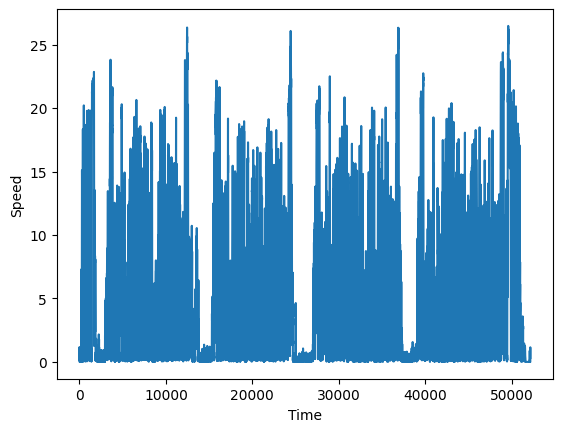

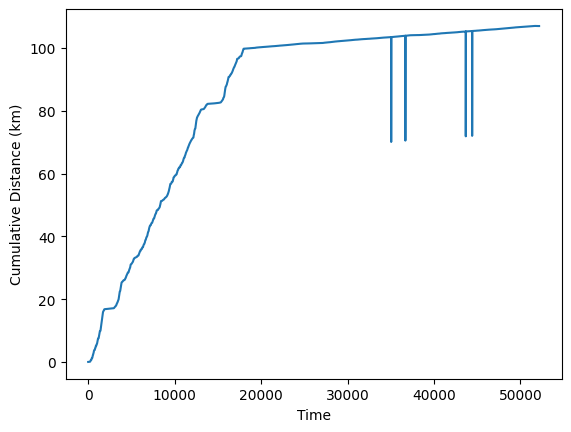

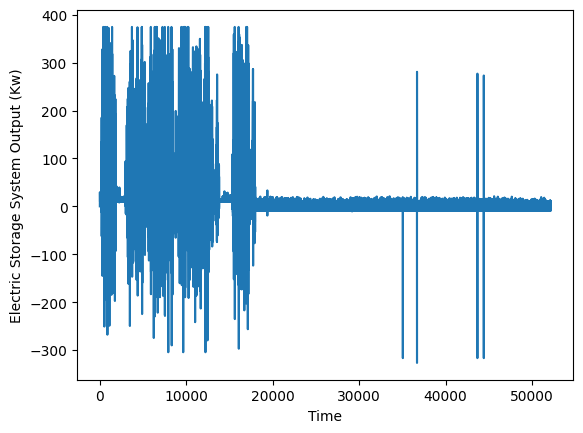

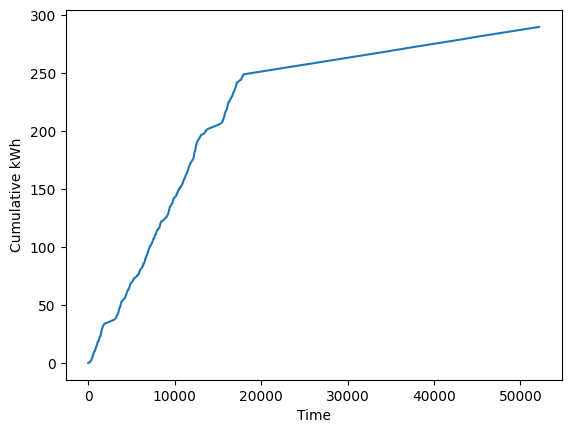

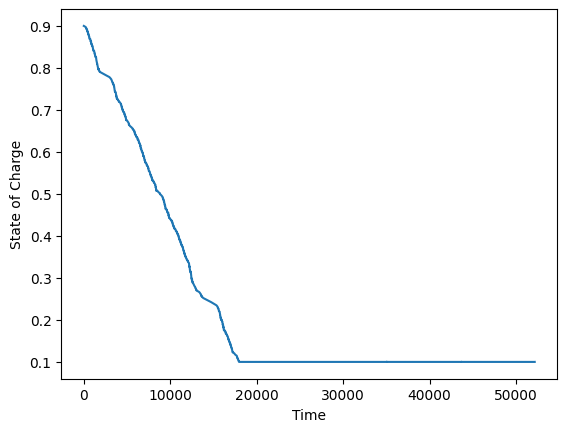

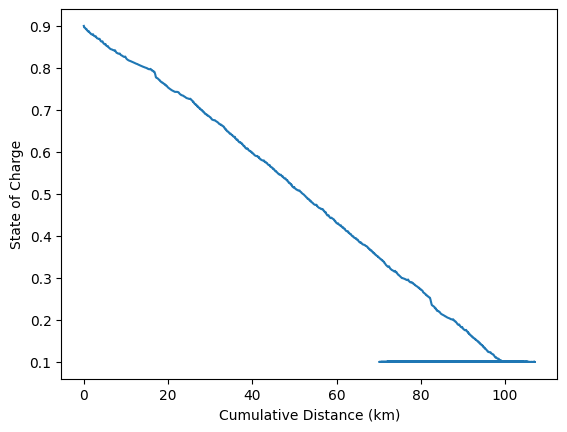

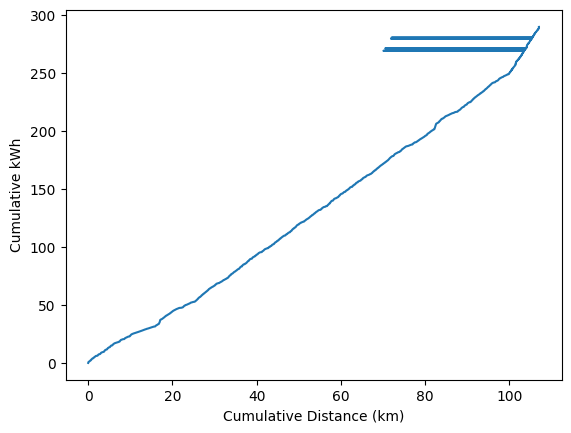

In [11]:
# Visualize
df = pd.DataFrame.from_dict(output)
df['speed'] = cyc.cycMps

# plt.rcParams['figure.figsize'] = [30, 20]

plt.plot(df['time'],df['speed'])
plt.xlabel('Time')
plt.ylabel('Speed')
plt.show()

plt.plot(df['time'],df['cumDistKm'])
plt.xlabel('Time')
plt.ylabel('Cumulative Distance (km)')
plt.show()

plt.plot(df['time'],sim_drive.essKwOutAch)
plt.xlabel('Time')
plt.ylabel('Electric Storage System Output (Kw)')
plt.show()

plt.plot(df['time'], df['cumKwh'])
plt.xlabel('Time')
plt.ylabel('Cumulative kWh')
plt.show()

plt.plot(df['time'],df['soc'])
plt.xlabel('Time')
plt.ylabel('State of Charge')
plt.show()

plt.plot(df['cumDistKm'],df['soc'])
plt.xlabel('Cumulative Distance (km)')
plt.ylabel('State of Charge')
plt.show()

plt.plot(df['cumDistKm'], df['cumKwh'])
plt.xlabel('Cumulative Distance (km)')
plt.ylabel('Cumulative kWh')
plt.show()

In [ ]:
print('Simulation summary:')
print(f'Final S.O.C.: {output["final_soc"]*100:.2f} %')
print(f'Distance driven: {output["distance_mi"]:.2f} miles. {output["distance_mi"]*km_per_mile:.2f} km')
print(f'Total time driven: {df["time"].iloc[-1] * 1/3600:.2f} hours')
print(f'Total energy required: {df["cumKwh"].iloc[-1]:.2f} kWh')